# Gas Simulation

In [1]:
# Import necessary libraries.
import os

import cv2 as cv
from matplotlib import pyplot as plt
import numpy as np
import pyglet
from tqdm import tqdm


#### Helper functions
Functions for handling color codes in image files.

In [2]:
def cell_type_to_color_index(cell_type):
    "Returns the index corresponding to a certain cell type for lookup of the corresponding color from the colorspace (see generate_colorspace())."
    return (int(cell_type) % 2, int(cell_type / 2) % 4, int(cell_type / 8) % 4)


def color_index_to_cell_type(color_index):
    "Returns the cell type corresponding to a certain color index of the colorspace (see generate_colorspace())."
    return int((color_index[0] + 1) * 4 + (color_index[1] + 1) * 4 + (color_index[2] + 1) * 2 - 1)


def generate_colorspace():
    """Returns a colorspace containing enough colors to describe all different types of valid cells.\n
    The colorspace is stored in a numpy array of shape (2, 4, 4, 3).\n
    The index of a certain color for a certain cell type can be found using the cell_type_to_color_index(cell_type) function.
    """
    output = np.zeros((2, 4, 4, 3), dtype='uint8')

    for i_i, i in enumerate(np.linspace(0, 255, 2, dtype='uint8')):
        for i_j, j in enumerate(np.linspace(0, 255, 4, dtype='uint8')):
            for i_k, k in enumerate(np.linspace(0, 255, 4, dtype='uint8')):
                output[i_i, i_j, i_k] = [i, j, k]

    output[cell_type_to_color_index(0b11111)], output[cell_type_to_color_index(
        0b10000)] = output[cell_type_to_color_index(0b10000)].copy(), output[cell_type_to_color_index(0b11111)].copy()

    return output


Functions for handling playing field image files.

In [3]:
def load_from_file(filename):
    img = cv.imread(filename)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

    colorspace = generate_colorspace()

    output = np.zeros(img.shape[:2], dtype='uint8')
    # Keeps track of the amount of parsed cells. If this is not equal to the total number of cells, the file contains invalid cells.
    health_counter = 0

    for cell_type in range(0b00000, 0b11111 + 1):
        color_index = cell_type_to_color_index(cell_type)
        color = colorspace[color_index]

        #                                                               Red                         Green                       Blue
        cell_indices = np.where(np.logical_and.reduce(((img[:, :, 0] == color[0]), (img[:, :, 1] == color[1]), (img[:, :, 2] == color[2]))))
        # Make parsed cells black.
        img[cell_indices] = [0, 0, 0]
        output[cell_indices] = cell_type
        health_counter += cell_indices[0].shape[0]

    # Check file validity.
    healthy_count = img.shape[0] * img.shape[1]
    if health_counter != healthy_count:
        print(
            f"WARNING: Image {filename} contains {healthy_count - health_counter} invalid cells.")
        cell_indices = np.where(np.logical_or.reduce(
            ((img[:, :, 0] != 0), (img[:, :, 1] != 0), (img[:, :, 2] != 0))))
        img[cell_indices] = [255, 255, 255]
        plt.figure()
        plt.title('Invalid cells shown in white.')
        plt.imshow(img)
        plt.show()

    return output


def generate_image(playing_field, scaling=1):
    playing_field_normalized = np.zeros(playing_field.shape, dtype='uint8')
    playing_field_normalized[np.where(playing_field > 0)] = 1
    playing_field_grayscale = playing_field_normalized * 255

    return cv.resize(cv.cvtColor(playing_field_grayscale, cv.COLOR_GRAY2RGB), None, fx=scaling, fy=scaling, interpolation=cv.INTER_NEAREST)


def save_to_file(filename, playing_field):
    img = generate_image(playing_field)

    colorspace = generate_colorspace()

    for cell_type in range(0b00000, 0b11111 + 1):
        color_index = cell_type_to_color_index(cell_type)
        color = colorspace[color_index]

        img[np.where(playing_field == cell_type)] = color

    img = cv.cvtColor(img, cv.COLOR_RGB2BGR)
    cv.imwrite(filename, img)


def print_image(playing_field, scaling=1):
    plt.figure()
    plt.imshow(generate_image(playing_field, scaling=scaling))


Simulation functions.

In [4]:
def movement_step(playing_field):
    # Movement controller
    stationary = np.bitwise_and(playing_field, 0b10000)

    up_moving = np.bitwise_and(playing_field, 0b01000)
    down_moving = np.bitwise_and(playing_field, 0b00100)
    right_moving = np.bitwise_and(playing_field, 0b00010)
    left_moving = np.bitwise_and(playing_field, 0b00001)

    up_moving_shifted = np.roll(up_moving, -1, axis=0)
    down_moving_shifted = np.roll(down_moving, 1, axis=0)
    right_moving_shifted = np.roll(right_moving, 1, axis=1)
    left_moving_shifted = np.roll(left_moving, -1, axis=1)

    return stationary + up_moving_shifted + down_moving_shifted + right_moving_shifted + left_moving_shifted


def collision_step(playing_field):
    # Collision detection.
    new_field = playing_field.copy()
    new_field[playing_field == 0b01100] = np.right_shift(playing_field[playing_field == 0b01100], 2)
    new_field[playing_field == 0b00011] = np.left_shift(playing_field[playing_field == 0b00011], 2)

    # Wall collision
    # Find all walls where a collision is happening. (0b10000 is a wall, anything greates is a wall + a particle.)
    walls = playing_field[playing_field > 0b10000]

    # Select particles going up (0b01000) or down (0b00100).
    select_up_down = walls & 0b01100
    # Select particles going left (0b00001) or right (0b00010).
    select_left_right = walls & 0b00011

    # Swap up and down.
    swapped_up_down = ((select_up_down << 1) | (select_up_down >> 1)) & 0b01100
    # Swap left and right.
    swapped_left_right = ((select_left_right << 1) | (select_left_right >> 1)) & 0b00011

    # Combine everything together again.
    final = swapped_up_down | swapped_left_right | 0b10000

    new_field[playing_field > 0b10000] = final
    return new_field


def time_step(playing_field, dt=1):
    if dt == 1:
        after_movement_step = movement_step(playing_field)
        after_collision_step = collision_step(after_movement_step)
    else:
        field = playing_field.copy()
        for i in range(0, dt):
            after_movement_step = movement_step(field)
            field = collision_step(after_movement_step)

        after_collision_step = field

    return after_collision_step


Video handling.

In [5]:
def write_video(playing_field, filename, n_frames, fps, scaling=1, timestep=1):
    extension = "avi"
    field = playing_field.copy()

    try:
        os.remove(f"{filename}.{extension}")
    except OSError:
        pass

    try:
        # Create VideoWriter object.
        # size=(width, height),    field.shape=(rows, cols)
        output = cv.VideoWriter(f"{filename}.{extension}", cv.VideoWriter_fourcc(*'FFV1'), fps, (field.shape[1] * scaling, field.shape[0] * scaling))

        for i in tqdm(range(0, n_frames)):
            field = time_step(field, dt=timestep)
            image = generate_image(field, scaling=scaling)
            output.write(image)
    finally:
        print("Closing stream...")
        output.release()


Other handy functions.

In [6]:
def generate_random_particles(playing_field, n_particles, constraint=None):
    field = playing_field.copy()

    if constraint is None:
        # ((row_min, col_min), (row_max, col_max))
        constraint = ((0, 0), playing_field.shape)

    row_indices = np.random.randint(constraint[0][0] + 1, constraint[1][0] - 1, n_particles)
    col_indices = np.random.randint(constraint[0][1] + 1, constraint[1][1] - 1, n_particles)
    particles = np.random.randint(0b00000, 0b10000, n_particles)

    field[row_indices, col_indices] = particles
    return field


### Sandbox

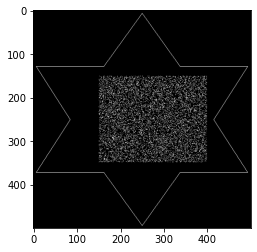

In [7]:
playing_field = load_from_file('fields/star.png')

'''
playing_field = generate_random_particles(playing_field, 300, constraint=((12, 12), (68, 68)))
#playing_field = generate_random_particles(playing_field, 100000, constraint=((6, 6), (494, 494)))'''
'''
playing_field[6:494:1,50:100:1] = 0b00010
playing_field[6:494,6:50] = 0b00000
playing_field[6:494:1,100:150:1] = 0b00000
playing_field[6:494,150:200] = 0b00010
'''
playing_field = generate_random_particles(playing_field, 10000, constraint=((150, 150), (350, 400)))
#playing_field = generate_random_particles(playing_field, 300, constraint=((12, 12), (68, 68)))
# playing_field = generate_random_particles(playing_field, 50000, constraint=((6, 6), (494, 240)))
'''
# Generate sin wave.
cols = np.arange(6, 494 + 1)
n_particles = 200
freq = 5
cols_n_particles = (n_particles * np.sin(2 * np.pi * freq * cols / n_cols) + n_particles).astype('int')
for col, col_n_particles in zip(cols, cols_n_particles):
    row_indices = np.random.randint(6, 494, col_n_particles)
    playing_field[row_indices, col] = 0b00010
    
playing_field = generate_random_particles(playing_field, 20000, constraint=((6, 6), (494, 494)))
'''

print_image(playing_field)

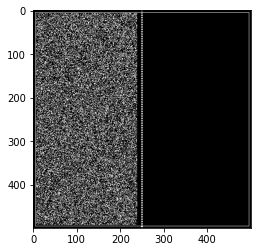

In [8]:
# playing_field = time_step(playing_field)
print_image(playing_field)

Code to generate video.

In [9]:
%%time
# In FPS
fps = 60
# In seconds.
duration = 60
# In number of frames.
n_frames = fps * duration
# write_video(playing_field, "simulations\\tiny_hole", n_frames, fps, scaling=1, timestep=4)

Wall time: 0 ns


### Live rendering
It's pretty terrible ngl.

In [12]:
scaling = 1

window = pyglet.window.Window(*((np.array(playing_field.shape) * scaling) + 100))
fps_display = pyglet.window.FPSDisplay(window=window)
view = None


def init():
    global view 
    update(0)
    pyglet.clock.schedule_interval(update, 1/120)


@window.event
def on_draw():
    global playing_field, view
    window.clear()
    fps_display.draw()

    view.blit((window.width - view.width) // 2, (window.height - view.height) // 2)


@window.event
def on_close():
    pyglet.clock.unschedule(update)


def update(dt):
    global playing_field, view
    playing_field = time_step(playing_field)
    img = generate_image(playing_field, scaling=scaling)
    imgdata = img.tobytes()
    view = pyglet.image.ImageData(img.shape[0], img.shape[1], 'RGB', imgdata)


try:
    init()
    pyglet.app.run()
finally:
    window.close()
    pyglet.app.exit()


KeyboardInterrupt: 